In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt


In [99]:
def load_cover_trace(filename):
    data = pd.read_csv(filename, delimiter=";")
    data = data.sort_values(by="frame.time_epoch").reset_index(drop=True)
    dummy_streams = "../results/collect/front_defended/100/dummy_streams.txt"
    dummy_ids = pd.read_csv(dummy_streams)
    display(dummy_ids)
    
    # Ensure that the trace starts with packet number zero
    assert data.loc[0, "quic.packet_number"] == 0
    start_time = data.loc[0, "frame.time_epoch"]
    
    # Drop all packets with packet number zero as they're only there for the starting time
    data = data[data["quic.packet_number"] != 0].reset_index(drop=True)
    
    # TODO: Should not include stremas which are not a part of the dummy traffic
    data["length"] = data["quic.stream.length"].map(
        lambda x: 0 if x is np.nan else sum(int(v) for v in x.split(","))
    )
    data["length"] += data["quic.padding_length"].fillna(0)
    data["length"] = data["length"].astype(int)
    data["is_outgoing"] = ~data["udp.srcport"].isin((443, 80))
    
    data["time"] = (data["frame.time_epoch"] - start_time) * 1e3
    
    data = data[["time", "length", "is_outgoing"]]
    
    data["time"] = pd.to_datetime(data["time"], unit="ms")
    data = data.groupby("is_outgoing").resample("5ms", on="time", origin="epoch")["length"].sum()
    return data.xs(True), data.xs(False)
    
    
(outgoing, incoming) = load_cover_trace("../results/collect/front_defended/100/front_cover_traffic.csv")
display(outgoing, incoming)

FileNotFoundError: [Errno 2] No such file or directory: '../results/collect/front_baseline/100/dummy_streams.txt'

In [92]:
def load_schedule(filename):
    data = pd.read_csv(filename, header=None, names=["time", "length"])
    data["is_outgoing"] = data["length"] > 0
    data["length"] = data["length"].abs()
    data = data.sort_values(by="time").reset_index(drop=True)
    
    data["time"] = pd.to_datetime(data["time"], unit="s")
    
    data = data.groupby("is_outgoing").resample("5ms", on="time", origin="epoch")["length"].sum()
    
    return data.xs(True), data.xs(False)

(baseline_out, baseline_in) = load_schedule("../results/collect/front_defended/100/schedule.csv")
display(baseline_out, baseline_in)

time
1970-01-01 00:00:00.025     700
1970-01-01 00:00:00.030     700
1970-01-01 00:00:00.035       0
1970-01-01 00:00:00.040    1400
1970-01-01 00:00:00.045       0
                           ... 
1970-01-01 00:00:01.440       0
1970-01-01 00:00:01.445       0
1970-01-01 00:00:01.450       0
1970-01-01 00:00:01.455       0
1970-01-01 00:00:01.460     700
Name: length, Length: 288, dtype: int64

time
1970-01-01 00:00:00.050    4200
1970-01-01 00:00:00.055    5600
1970-01-01 00:00:00.060    2100
1970-01-01 00:00:00.065    2800
1970-01-01 00:00:00.070    7700
                           ... 
1970-01-01 00:00:00.615       0
1970-01-01 00:00:00.620       0
1970-01-01 00:00:00.625       0
1970-01-01 00:00:00.630       0
1970-01-01 00:00:00.635     700
Name: length, Length: 118, dtype: int64

time
1970-01-01 00:00:00.025    1164
1970-01-01 00:00:00.030      50
1970-01-01 00:00:00.035    1454
1970-01-01 00:00:00.040      50
1970-01-01 00:00:00.045      50
                           ... 
1970-01-01 00:00:01.440      50
1970-01-01 00:00:01.445      50
1970-01-01 00:00:01.450      50
1970-01-01 00:00:01.455      50
1970-01-01 00:00:01.460     750
Name: length, Length: 288, dtype: int64

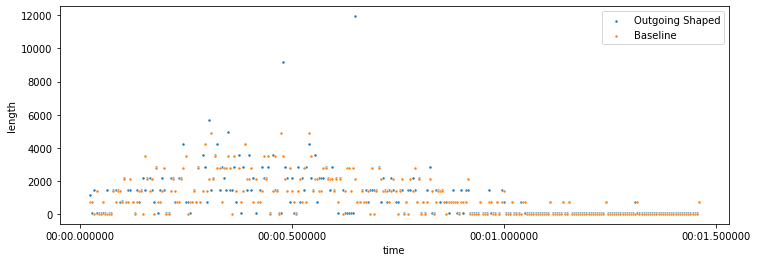

In [93]:
figure, axes = plt.subplots(1, 1, figsize=(12, 4))
outgoing_shift = outgoing + 50
display(outgoing_shift)
sns.scatterplot(x="time", y="length", data=outgoing_shift.to_frame().reset_index(), marker='.', ax=axes, label="Outgoing Shaped")
sns.scatterplot(x="time", y="length", data=baseline_out.to_frame().reset_index(), marker='.', ax=axes, label="Baseline")

figure.savefig("/tmp/out.png", dpi=300, bbox_inches="tight")

Defended  Baseline
time                                       
1970-01-01 00:00:00.025      1114       700
1970-01-01 00:00:00.030         0       700
1970-01-01 00:00:00.035      1404         0
1970-01-01 00:00:00.040         0      1400
1970-01-01 00:00:00.045         0         0
...                           ...       ...
1970-01-01 00:00:01.440         0         0
1970-01-01 00:00:01.445         0         0
1970-01-01 00:00:01.450         0         0
1970-01-01 00:00:01.455         0         0
1970-01-01 00:00:01.460       700       700

[288 rows x 2 columns]

time
1970-01-01 00:00:00.025   NaN
1970-01-01 00:00:00.030   NaN
1970-01-01 00:00:00.035   NaN
1970-01-01 00:00:00.040   NaN
1970-01-01 00:00:00.045   NaN
                           ..
1970-01-01 00:00:01.440   NaN
1970-01-01 00:00:01.445   NaN
1970-01-01 00:00:01.450   NaN
1970-01-01 00:00:01.455   NaN
1970-01-01 00:00:01.460   NaN
Length: 288, dtype: float64

Scipy computed Pearson r: 0.614107839576657 and p-value: 3.0315346040340764e-31


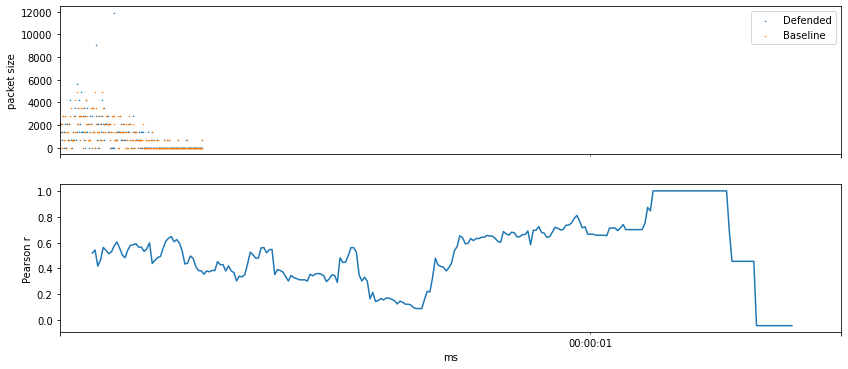

In [98]:
import scipy.stats as stats
r_window_size = 24

df = pd.concat([outgoing, baseline_out], keys=["Defended", "Baseline"], axis=1).fillna(0)
bins= np.arange(len(df))

rolling_r = df['Defended'].rolling(window=r_window_size, center=True).corr(df['Baseline'])
display(df)
display(rolling_r)

f,ax=plt.subplots(2,1,sharex=True, figsize=(14,6))
ax[0].scatter(x=bins, y=df["Defended"], label="Defended", s=1.0, marker='1')
ax[0].scatter(x=bins, y=df["Baseline"], label="Baseline", s=1.0, marker='2')
#sns.scatterplot(x="time", y="length", data=outgoing.to_frame().reset_index(), marker='.', ax=ax[0], label="Outgoing Shaped")
#sns.scatterplot(x="time", y="length", data=baseline_out.to_frame().reset_index(), marker='.', ax=ax[0], label="Baseline")
ax[0].set(xlabel='ms',ylabel='packet size')
ax[0].legend()
rolling_r.plot(ax=ax[1])
ax[1].set(xlabel='ms',ylabel='Pearson r')
f.show()

r,p = stats.pearsonr(df["Defended"], df["Baseline"])
print(f"Scipy computed Pearson r: {r} and p-value: {p}")

In [7]:
data["time"] = pd.IntervalIndex(pd.cut(data["time"], bins=np.arange(0, 1500, 1), right=False)).left
data.groupby(["time", "is_outgoing"]).sum()


NameError: name 'data' is not defined

In [16]:
data["length"] = data["quic.stream.length"] + data["quic.padding_length"].fillna(0)
data

frame.time_epoch  quic.stream.length  quic.padding_length  udp.srcport  \
0        1.610628e+09                   0               1223.0          443   
1        1.610628e+09                   0                  6.0          443   
2        1.610628e+09                 207                  NaN        56793   
3        1.610628e+09                   0                  2.0          443   
4        1.610628e+09                   0                  1.0          443   
..                ...                 ...                  ...          ...   
354      1.610628e+09                 700                  NaN          443   
355      1.610628e+09                 700                  NaN          443   
356      1.610628e+09                   0                700.0        56793   
357      1.610628e+09                   0                700.0        56793   
358      1.610628e+09                   0                700.0        56793   

     length  
0    1223.0  
1       6.0  
2     207.0  
3       2.0  
4       1.0  
..      ...  
354   700.0  
355   700.0  
356   700.0  
357   700.0  
358   700.0  

[359 rows x 5 columns]

In [18]:
data = data.sort_values(by="frame.time_epoch")
data["frame.time_epoch"] = data["frame.time_epoch"] - data["frame.time_epoch"][0]

In [21]:
data["direction"] = data["udp.srcport"].isin((443, 80))
data

frame.time_epoch  quic.stream.length  quic.padding_length  udp.srcport  \
0            0.000000                   0               1223.0          443   
1            0.022981                   0                  6.0          443   
2            0.025162                 207                  NaN        56793   
3            0.028513                   0                  2.0          443   
4            0.054022                   0                  1.0          443   
..                ...                 ...                  ...          ...   
354          1.479844                 700                  NaN          443   
355          1.479901                 700                  NaN          443   
356          1.480408                   0                700.0        56793   
357          1.483931                   0                700.0        56793   
358          1.484259                   0                700.0        56793   

     length  direction  
0    1223.0       True  
1       6.0       True  
2     207.0      False  
3       2.0       True  
4       1.0       True  
..      ...        ...  
354   700.0       True  
355   700.0       True  
356   700.0      False  
357   700.0      False  
358   700.0      False  

[359 rows x 6 columns]

In [1]:
import numpy as np
from matplotlib import pyplot as plt
n_noshape = 1500
sigma = 1

r = np.random.rayleigh(sigma, n_noshape)
tx_ts = np.random.choice(r, int(0.3*n_noshape))
tx_ts.sort()
rx_ts = np.setdiff1d(r, tx_ts)
rx_ts.sort()
trace = r
trace.sort()

In [2]:
tx_sizes = np.random.randint(75, 89, len(tx_ts))
rx_sizes = np.random.randint(1250, 1515, len(rx_ts))
tx_trace = [i for i in zip (tx_ts, tx_sizes)]
tx_trace.sort(key=lambda t: t[0])
rx_trace = [i for i in zip (rx_ts, -rx_sizes)]
rx_trace.sort(key=lambda t: t[0])
trace = tx_trace + rx_trace
trace.sort(key=lambda t: t[0])
print(trace[:10])
print(trace[-10:])

[(0.05558517475582432, -1288), (0.05610813959058147, -1311), (0.06518756820619391, -1254), (0.09102037853234415, -1268), (0.09629301165491655, 81), (0.09733987368573571, -1499), (0.13202776016716805, -1374), (0.13357384084121643, -1439), (0.14467009846140114, -1451), (0.15233601517547662, -1348)]
[(3.1441080805047017, 81), (3.1508418706646175, 75), (3.1508418706646175, 84), (3.196156163929696, -1486), (3.2718621959319236, 83), (3.281224791266335, 77), (3.4256300944800016, -1348), (3.6270084866016323, 88), (3.63491406577518, -1381), (3.7923770065211, -1496)]


In [3]:
# now create the FRONt dummy trace
N_TX = 900
N_RX = 1200
W_min = 0.5
W_max = 2
dummy_sz = 700
n_tx = np.random.randint(1, N_TX)
n_rx = np.random.randint(1, N_RX)
w_tx = np.random.rand()*(W_max-W_min) + W_min
w_rx = np.random.rand()*(W_max-W_min) + W_min

tx_dummy_ts = np.random.rayleigh(w_tx, n_tx)
rx_dummy_ts = np.random.rayleigh(w_rx, n_rx)


tx_dummy_trace = [(ts, dummy_sz) for ts in tx_dummy_ts]
tx_dummy_trace.sort(key=lambda t: t[0])
rx_dummy_trace = [(ts, -dummy_sz) for ts in rx_dummy_ts]
rx_dummy_trace.sort(key=lambda t: t[0])

print("n_tx: {}".format(n_tx))
print("n_rx: {}".format(n_rx))
print("w_tx: {}".format(w_tx))
print("w_rx: {}".format(w_rx))

defended = trace + tx_dummy_trace + rx_dummy_trace
defended.sort(key=lambda t: t[0])
print(defended[:10])
print(defended[-10:])

n_tx: 199
n_rx: 166
w_tx: 1.735246079900916
w_rx: 1.8088429465212004
[(0.05558517475582432, -1288), (0.05610813959058147, -1311), (0.06518756820619391, -1254), (0.09102037853234415, -1268), (0.09629301165491655, 81), (0.09733987368573571, -1499), (0.1291080374371181, -700), (0.13202776016716805, -1374), (0.13357384084121643, -1439), (0.1437118864650141, -700)]
[(5.109646928776287, -700), (5.260106702169411, -700), (5.266975696007154, 700), (5.3766099395949, 700), (5.3797184532248705, -700), (5.40642728181092, -700), (5.535601943120745, 700), (5.683694064854406, 700), (5.891939091774457, 700), (6.929246292068966, -700)]


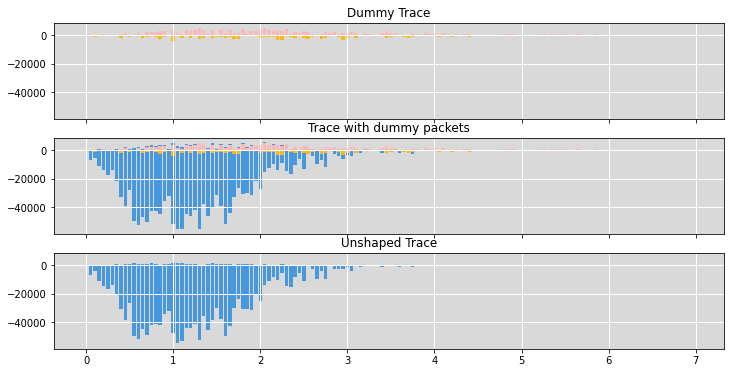

In [4]:
def make_binned(trace, bins): 
    #trace_ts = [ts for (ts, _) in trace]
    #bins = np.arange(0, max(trace_ts)+rate, rate)
    bins = np.append(bins,100000)
    bin_idx = 0
    binned = np.zeros(len(bins))
    for (ts, sz) in trace:
        if ts < bins[bin_idx+1]:
            binned[bin_idx] += sz
        else:
            while ts >= bins[bin_idx+1]:
                bin_idx+=1
            binned[bin_idx] += sz
    return (bins[:-1], binned[:-1])

PALETTE = {'blue': '#4898de',
           'purple': '#a7a3e0',
           'fucsia': '#dab4da',
           'pink': '#f4cddb',
           'rosepink': '#ffb7b6',
           'coral': '#ffae75',
           'orange': '#f7b819'}

fig, ax = plt.subplots(3, 1, sharex=True, sharey=True, figsize=(12,6))
ax[0].set_title("Dummy Trace")
ax[0].set_facecolor('0.85')
ax[0].grid(color='w', linewidth=1)
ax[1].set_title("Trace with dummy packets")
ax[1].set_facecolor('0.85')
ax[1].grid(color='w', linewidth=1)
ax[2].set_title("Unshaped Trace")
ax[2].set_facecolor('0.85')
ax[2].grid(color='w', linewidth=1)

rate = 0.05
defended_ts = [ts for (ts, _) in defended]
bins = np.arange(0, max(defended_ts)+rate, rate)

(rx_dummy_bins, rx_dummy_binned) = make_binned(rx_dummy_trace, bins)
(tx_dummy_bins, tx_dummy_binned) = make_binned(tx_dummy_trace, bins)
(rx_bins, rx_binned) = make_binned(rx_trace, bins)
(tx_bins, tx_binned) = make_binned(tx_trace, bins)

# Print dummy traffic
ax[0].bar(rx_dummy_bins, rx_dummy_binned, width=0.04, color=PALETTE["orange"])
ax[0].bar(tx_dummy_bins, tx_dummy_binned, width=0.04, color=PALETTE["rosepink"])

# Print defended
bottoms = np.zeros(len(rx_binned))
bottoms[:len(rx_dummy_binned)] = rx_dummy_binned
ax[1].bar(rx_dummy_bins, rx_dummy_binned, width=0.04, color=PALETTE["orange"])
ax[1].bar(rx_bins, rx_binned, width=0.04, bottom=bottoms, color=PALETTE["blue"])

bottoms = np.zeros(len(tx_binned))
bottoms[:len(tx_dummy_binned)] = tx_dummy_binned
ax[1].bar(tx_dummy_bins, tx_dummy_binned, width=0.04, color=PALETTE["rosepink"])
ax[1].bar(tx_bins, tx_binned, width=0.04, bottom=bottoms, color=PALETTE["blue"])

# print unshaped
ax[2].bar(rx_bins, rx_binned, width=0.04, color=PALETTE["blue"])
ax[2].bar(tx_bins, tx_binned, width=0.04, color=PALETTE["blue"])

plt.show()

# Dynamic TimeWarping

1918 1553
D: 350313.0


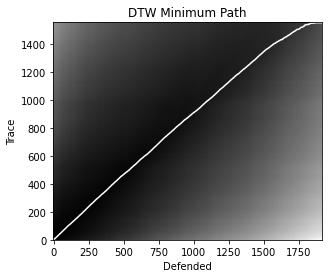

In [5]:
from dtw import dtw, accelerated_dtw

t1 = np.array([sz for (_, sz) in defended])
t2 = np.array([sz for (_, sz) in trace])
print(len(t1), len(t2))

d, cost_matrix, acc_cost_matrix, path = accelerated_dtw(t1,t2, dist='euclidean')

print("D: {}".format(d))

plt.imshow(acc_cost_matrix.T, origin='lower', cmap='gray', interpolation='nearest')
plt.plot(path[0], path[1], 'w')
plt.xlabel('Defended')
plt.ylabel('Trace')
plt.title('DTW Minimum Path')
plt.show()

D: 228920.0


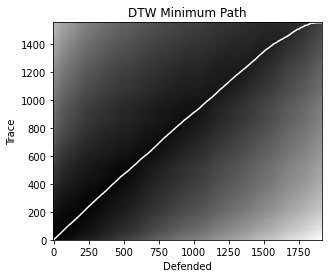

In [6]:
t3 = np.array([abs(sz) for (_, sz) in defended])
t4 = np.array([abs(sz) for (_, sz) in trace])

d, cost_matrix, acc_cost_matrix, path = accelerated_dtw(t3,t4, dist='euclidean')

print("D: {}".format(d))

plt.imshow(acc_cost_matrix.T, origin='lower', cmap='gray', interpolation='nearest')
plt.plot(path[0], path[1], 'w')
plt.xlabel('Defended')
plt.ylabel('Trace')
plt.title('DTW Minimum Path')
plt.show()

# Pearson 

Needs the same range of values, so the traces are binned to the same rate

6.929246292068966
[6926. 6927. 6928. 6929. 6930.]
6931 6931 6931
[   0.    0.    0. -700.    0.]
[0. 0. 0. 0. 0.]
Scipy computed Pearson r: 0.9709562903911637 and p-value: 0.0


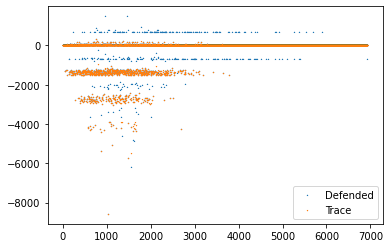

In [20]:
import scipy.stats as stats

# rate in milliseconds of binning the packets
RATE = 1.0

(tail_df, _) = defended[-1]
(tail_tr, _) = trace[-1]
x_lim = max(tail_df, tail_tr)
print(x_lim)
bins = np.arange(0, x_lim*1000 + RATE, RATE)
print(bins[-5:])

(_, binned_df) = make_binned([(1000*ts, sz) for (ts, sz) in defended], bins)
(_, binned_tr) = make_binned([(1000*ts, sz) for (ts, sz) in trace], bins)

print(len(bins), len(binned_df), len(binned_tr))
print(binned_df[-5:])
print(binned_tr[-5:])

r,p = stats.pearsonr(binned_df, binned_tr)
print(f"Scipy computed Pearson r: {r} and p-value: {p}")
plt.scatter(bins, binned_df, label="Defended", s=0.5, marker='1')
plt.scatter(bins, binned_tr, label="Trace", s=0.5, marker='2')
plt.legend()
plt.show()

## Rolling window Pearson

        Defended  Trace
0.0          0.0    0.0
1.0          0.0    0.0
2.0          0.0    0.0
3.0          0.0    0.0
4.0          0.0    0.0
...          ...    ...
6926.0       0.0    0.0
6927.0       0.0    0.0
6928.0       0.0    0.0
6929.0    -700.0    0.0
6930.0       0.0    0.0

[6931 rows x 2 columns]


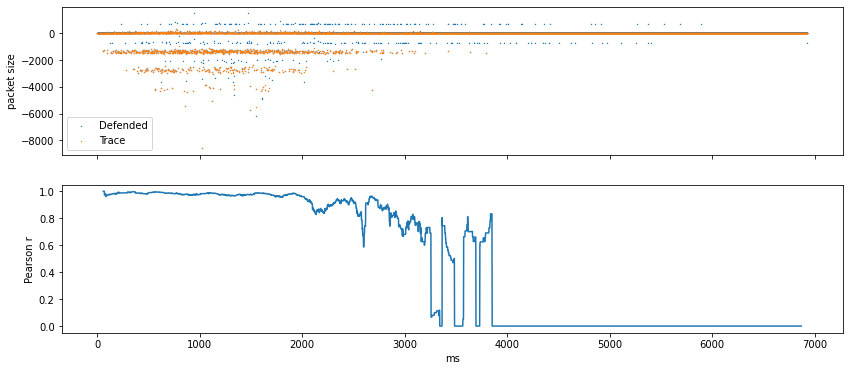

In [21]:
import pandas as pd
r_window_size = 120

df = pd.DataFrame(list(zip(binned_df, binned_tr)), index=bins, columns=["Defended", "Trace"])
print(df)

rolling_r = df['Defended'].rolling(window=r_window_size, center=True).corr(df['Trace'])

f,ax=plt.subplots(2,1,sharex=True, figsize=(14,6))
ax[0].scatter(bins, binned_df, label="Defended", s=0.5, marker='1')
ax[0].scatter(bins, binned_tr, label="Trace", s=0.5, marker='2')
ax[0].set(xlabel='ms',ylabel='packet size')
ax[0].legend()
rolling_r.plot(ax=ax[1])
ax[1].set(xlabel='ms',ylabel='Pearson r')
f.show()

***

# Using real traces

In [19]:
import csv

# get dummy ids
dummy_ids = []
with open("../../traces/saves/vanilla_ids.csv") as csvfile:
    rdr = csv.reader(csvfile)
    for row in rdr:
        dummy_ids.append(int(row[0]))

# get dummy rayleigh schedule
dummy_schedule = []
with open("../../traces/saves/vanilla_schedule.csv") as csvfile:
    rdr = csv.reader(csvfile)
    for row in rdr:
        ts = float(row[0])
        sz = int(row[1])
        dummy_schedule.append((ts,sz))

# get vanilla shaped
with open("../../traces/vanilla-shaped.csv") as csvfile:
    vanilla_shaped = pd.read_csv(
        csvfile, header=None, names=["timestamp", "size"])
    assert not (vanilla_shaped["size"] > 1600).any()

print(vanilla_shaped)

# get vanilla unshaped
with open("../../traces/vanilla-unshaped.csv") as csvfile:
    vanilla_unshaped = pd.read_csv(
        csvfile, header=None, names=["timestamp", "size"])
    assert not (vanilla_unshaped["size"] > 1600).any()

print(vanilla_unshaped)

      timestamp  size
0      0.000000  1399
1      0.010095  -171
2      0.010465 -1294
3      0.010467  -435
4      0.014193  1399
...         ...   ...
1904   2.461273   770
1905   2.514829   770
1906   2.688720   770
1907   2.725236   770
1908   2.725785    86

[1909 rows x 2 columns]
      timestamp  size
0      0.000000  1399
1      0.014106  -171
2      0.015289 -1294
3      0.015291  -424
4      0.018035  1399
...         ...   ...
1681   0.861065    77
1682   0.862555    78
1683   0.864234    78
1684   0.865598    78
1685   0.867639    81

[1686 rows x 2 columns]


In [26]:
# create target
vanilla_target = pd.DataFrame(dummy_schedule, columns=['timestamp', 'size'])
vanilla_target = vanilla_target.sort_values(by='timestamp')

vanilla_target = vanilla_target.append(vanilla_unshaped, ignore_index=True)

print(vanilla_target)



      timestamp  size
0      0.050335  -700
1      0.050461  -700
2      0.050690  -700
3      0.050974  -700
4      0.051106  -700
...         ...   ...
2602   0.861065    77
2603   0.862555    78
2604   0.864234    78
2605   0.865598    78
2606   0.867639    81

[2607 rows x 2 columns]


2.7272533709999998
[2724. 2725. 2726. 2727. 2728.]
2729 2729 2729
[  0. 856.   0.   0.   0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[       0.        0.        0. -1800974.        0.]
[2724. 2725. 2726. 2727. 2728.]
        Defended     Target
0.0       1399.0        0.0
1.0          0.0        0.0
2.0          0.0        0.0
3.0          0.0        0.0
4.0          0.0        0.0
...          ...        ...
2724.0       0.0        0.0
2725.0     856.0        0.0
2726.0       0.0        0.0
2727.0       0.0 -1800974.0
2728.0       0.0        0.0

[2729 rows x 2 columns]


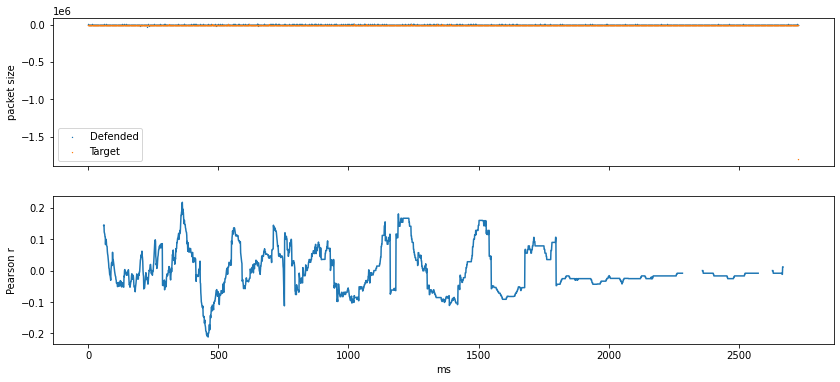

In [37]:
# rate in milliseconds of binning the packets
RATE = 1.0

tail_df = vanilla_shaped['timestamp'].max()
tail_tr = vanilla_target['timestamp'].max()
x_lim = max(tail_df, tail_tr)
print(x_lim)
bins = np.arange(0, x_lim*1000 + RATE, RATE)
print(bins[-5:])

(_, binned_df) = make_binned([(1000*ts, int(sz)) for [ts, sz] in vanilla_shaped.values], bins)
(_, binned_tr) = make_binned([(1000*ts, int(sz)) for [ts, sz] in vanilla_target.values], bins)

print(len(bins), len(binned_df), len(binned_tr))
print(binned_df[-5:])
print(binned_tr[:20])
print(binned_tr[-5:])
print(bins[-5:])

r_window_size = 120

df = pd.DataFrame(list(zip(binned_df, binned_tr)), index=bins, columns=["Defended", "Target"])
print(df)

rolling_r = df['Defended'].rolling(window=r_window_size, center=True).corr(df['Target'])

f,ax=plt.subplots(2,1,sharex=True, figsize=(14,6))
ax[0].scatter(bins, binned_df, label="Defended", s=0.5, marker='1')
ax[0].scatter(bins, binned_tr, label="Target", s=0.5, marker='2')
ax[0].set(xlabel='ms',ylabel='packet size')
ax[0].legend()
rolling_r.plot(ax=ax[1])
ax[1].set(xlabel='ms',ylabel='Pearson r')
f.show()